In [1]:
import jax
import jax.numpy as jnp
import matplotlib.pyplot as plt
from IPython import display
from jax.example_libraries import optimizers

import hyperwave as hw

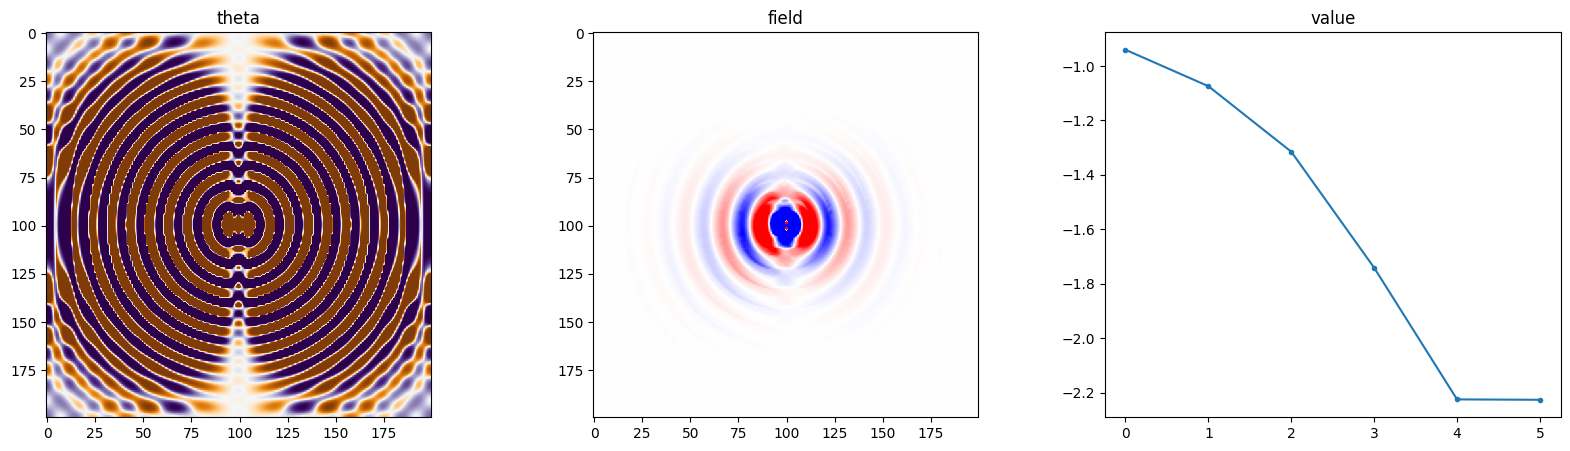

In [2]:
def loss(theta):
    theta = jnp.clip(1 + 3 * theta[..., None], 1, 4)
    theta = (theta + jnp.flip(theta, axis=0)) / 2
    theta = (theta + jnp.flip(theta, axis=1)) / 2
    permittivity = jnp.stack(
        [
            (theta + jnp.roll(theta, axis=0, shift=-1)) / 2,
            (theta + jnp.roll(theta, axis=1, shift=-1)) / 2,
            theta,
        ]
    )
    num_freqs = 1
    axis = 1
    shape = permittivity.shape[-3:]
    center = tuple(s // 2 for s in shape)
    domain = hw.solver.Domain(
        grid=tuple(jnp.ones(s) for s in shape),
        freq_band=hw.solver.FreqBand(0.2, 0.21, num_freqs),
        permittivity=permittivity,
        conductivity=1e-1 * jnp.ones((3,) + shape),
    )
    source = hw.solver.Source(
        values=jnp.zeros((num_freqs, 3, 1, 1, 1)).at[:, axis, ...].set(1.0),
        offset=center,
    )
    field = hw.solver.field_solve(domain, source, tol=1e-7)
    value = -jnp.linalg.norm(field[:, axis, center[0], center[1], center[2]])
    aux = field[0, axis, :, :, 0]
    return value, aux


def optimize(
    init_theta,
    learning_rate,
    num_iters,
):

    init_fn, update_fn, params_fn = optimizers.adam(learning_rate)

    def step(i, state):
        (value, aux), grads = jax.value_and_grad(loss, has_aux=True)(params_fn(state))
        state = update_fn(0, jnp.real(grads), state)
        return state, value, aux

    value_hist = []

    state = init_fn(init_theta)

    for i in range(num_iters):
        state, value, aux = step(i, state)
        value_hist.append(value)
        theta = params_fn(state)

        # Display progress
        display.clear_output(wait=True)

        plt.figure(figsize=(20, 5))
        plt.subplot(1, 3, 1)
        plt.title("theta")
        plt.imshow(theta.T, cmap="PuOr", vmin=0, vmax=1)
        plt.subplot(1, 3, 2)
        plt.title("field")
        plt.imshow(jnp.real(aux).T, cmap="bwr", vmin=-1e-2, vmax=+1e-2)
        plt.subplot(1, 3, 3)
        plt.title("value")
        plt.plot(value_hist, ".-")
        plt.show()

    return theta


theta = optimize(
    init_theta=0.5 * jnp.ones((200, 200)),
    learning_rate=1e-1,
    num_iters=6,
)